# PCQI Problem Set 4 NQS: Neural (Network) Quantum (Many-Body) States from Restricted Boltzmann Machines

There are four exercises interpersed through the notebook.

<i>01-Mar-2022 K. Schalm.</i>

## Learning Goal: 
We use a Restricted Boltzmann machine to find a representative parametrization of the ground state wavefunction of the 1D transverse field Ising Model: the ground-state wavefunction-squared is a probability distribution. The goal is to show how a restricted Boltzmann machine provides a method to compute representations of probability distributions efficiently. 

### Overview
One of the fundamental principles of Quantum Mechanics is Born's rule: the absolute-value-squared of the wavefunction gives the probability density. Given the wavefunction $\Psi(x)$, the expectation value of any observable ${\cal O}$ equals 
$$
\langle\Psi| {\cal O}|\Psi \rangle = \int dx \bar{\Psi}(x)\Psi(x) {\cal O}(x) \simeq \int dx P(x){\cal O}(x)
$$
Most of time one wants the ground state wavefunction. This is the wave-function that the system wishes to relax to when interacting with an external system, or the one that dominates at low temperatures where quantum effects are important. In classic systems, e.g. the  Ising model, we know what the ground state wavefunction is, but there are many (many body strongly) interacting systems where this is a real puzzle. The prototypical example is the Ising model in a *transverse* magnetic field. From its Hamiltonian
$$
H = -J\sum_{\langle i,j\rangle_{\text{near.neigh}}}\sigma^z_i\sigma^z_j - B\sum_i\sigma^x_i
$$
one sees that the external magnetic force $B\sigma^x_i$ does not commute with the Ising interaction. As a consequence the Hamiltonian is not easily reducible to a subsystem analysis.

In 2016 Carleo and Troyer had the insight that Restricted Boltzmann Machines as generators of representations of probability densities could equally well be used to generate representations of probability amplitudes, i.e. many-body wavefunctions <a href=https://arxiv.org/abs/1606.02318>[arXiv:1606.02318]</a>. In essence a Restricted Boltzmann Machine computation is just a specific form of a variational wavefunction solution. Carleo and Troyer called these NQS: Neural (Network) Quantum States. Representation in the sense of a parameterized/fixed format probability distribution/quantum state.

Here we will use this insight of Carleo and Troyer to compute the ground state wavefunction of the 1D transverse field Ising Model quoted above. It is one of the examples Carleo and Troyer discuss as a benchmark, as the 1D system is actually solvable by other means (Jordan-Wigner transformation to free fermions). The 2D transverse field Ising model is not solvable, however. Nor are other 1D interacting quantum many-body systems.

Additional resources:
1. K. Fischer et al Course project Stanford University <a href=https://github.com/kafischer/neural-quantum-states>Neural Quantum States</a>

## The NQS representation of the ground state of the transverse field Ising Model ##

### NQSRBM vs Learning RBM ###

There is one important technical difference between a "learning" Restricted Boltzmann Machine and a "NQS" Restricted Boltzmann machine: 
- The objective of a "learning" RBM is to find a representation of the probability distribution $P(X_{data})$ in terms of $P_{RMB}= \frac{1}{Z}\exp(-a\cdot v- c \cdot h - h\cdot W\cdot v)$. To do so it designs a cost-function: in practice it minimizes the log-likelihood $\log(P_{RMB})(v|parameters)=\log \frac{1}{Z}\sum_h P_{RMB}(v,h|parameters)$ (as explained in lecture this depends on $P_{data}$).

- The objective NQS-RBM is to find a representation of the probability amplitude $\Psi_{GS}$ in terms of a $\Psi_{RMB}= \frac{1}{Z}\exp(-a\cdot \sigma^z- c \cdot h - h\cdot W\cdot \sigma^z)$ that is *defined* by *minimization* of the eigen-energy of the Ising Hamiltonian.
$$
E=\frac{\langle \Psi_{RMB}| H |\Psi_{RMB}\rangle}{\langle \Psi_{RMB}|\Psi_{RMB}\rangle} ~~~\text{such that}~~~\partial_{a,c,W} E = 0
$$


In other words, in learning one designs a cost-function comparing data and model. In NQS the goal is already defined by a specific cost function.
This means that 
1. We do not have the analogue to $P_{data}$, a $\Psi_{data}$, to compare to. Instead we follow the variational solution protocol in QM and generate first some guess $\Psi_{initial}$. 
2. The minimization functional is now not the intrinsic probability distribution but $\langle H\rangle_{RBM}$.
For the rest we directly apply the RBM learning protocol.

To recapitulate this.
1. For a 1D Ising model with $N_v$ spins, we create an RBM with $N_v$ visible and $N_h$ hidden spins.
2. We make the ansatz that the ground state wave-function, formally equal $\Psi_{exact} =\sum c_{n}|{\cal S}_n\rangle$, where ${\cal S}_n$ are a Hilbert space basis of all possible spins, can be approximately described by the ansatz 
$$
\Psi_{model}=\exp(-a^i\sigma_i^z -c_{\alpha}h^{\alpha} - h^{\alpha}W_{\alpha}^i\sigma^z_i)
$$ 
This is mathematically like a probability distribution, with the difference that the coefficients $W_{\alpha}^i, a^i,c_{\alpha}$ can be complex.

3. We use Markov Chain Monte Carlo (either Metropolis or (block) Gibbs sampling) to give a representation of this wavefunction over a finite smaller representative number of states $N_{MCMC}$ instead of over all states $dim(Hilbert)$. (Note that in spite of the natural suitability for (block) Gibbs sampling, it is computationally more expensive. For "learning" RBMs, where one can average over data this is solved by k-contrastive divergence. Here we cannot do so, and for speed we ususally use Metropolis).
4. We compute the derivative of $E$ w.r.t. the (complex) RBM parameters $W_{\alpha}^i, a^i,c_{\alpha}$
5. We update the RBM parameters according to  $$ W_{t+1}=W_t - \epsilon \partial_{parameters} E$$ with the learning rate $\epsilon$ a tunable parameter. (Note that Carleo and Troyer, use a very fancy Sorella second order updater, that is more efficient. We will use simple gradient descent.)
6. Repeat from 3. until desired accuracy.

---
**Exercise 1:** 

The idea of a variational wave-function solution to finding the QM groundstate is to find an efficient and computable solution to the formal problem of determining the coefficients $c_n$. On how many parameters does the exact wave-function depend in a 1D transverse-field Ising model with $L$ sites? On how many parameters does the variational RBM model ansatz depend? What do you conclude?

---

L sites means that we have $N_v = L$ (visisble) spins and $N_h$ possible spin configurations. The exact wavefunction in its generality $\Psi_{exact} = \sum c_{n}|{\cal S}_n\rangle $, given above, is a sum over all possible spin configurations (in which |{\cal S}_n\rangle represents a single configuration of all L spins.). For each spin being $\pm 1$, we get $2^{N_v} =  2^{L} = N_h$ different terms/ complex coefficients $C_{n}$. Since we, numerically can't estimate complex numbers directly, this corresponds to $2^{L+1}$ real parameters in total for $\Psi_{exact}$.
The variational RBM model ansatz 
$$ 
\Psi_{model}=\exp(-a^i\sigma_i^z -c_{\alpha}h^{\alpha} - h^{\alpha}W_{\alpha}^i\sigma^z_i)
$$
depends, additionally to the $2^{L+1}$ parameters $C_{n}$, on the number of visible spins $N_v = L$. Both in order for the model to make sense, as well as for a correct einstein summation in the ansatz. I.e. $2*L$ real parameters to add.  Finally for the coupling-matrix $W_{\alpha}^i$ of size $(N_v \times N_h)$, this gives additional $2^{L+2} \cdot L$ real parameters to estimate.
 Total for $\Psi_{model}$ is thus $(2^{L+2} + 2) \cdot L + 2^{L+1}$ real paramters.

    We conclude from this that the parameter space for the ground state ansatz is already very complex and being held very general, i.e. low bias and high variance model. This makes the problem very hard to solve since one, usually, has to look around the whole paramter space for an optimal solution and is far more likely to land in local minima rather than happen to find a good solution using regular variational methods. The problem is even enlarged in the RBM method as it requires even more parameters (hidden nodes) to be learned. Also a good RBM will depend with its performance strongly on initialization of the ansatz and, therefore, also on the way we utilize Metropolis + gradient descent.

### Preliminaries ###

There is a subtle difference between the NQS ansatz and the standard RBM anstatz. The ansatz for the wavefunction is expressed in terms of $\sigma^z_i$, but $\sigma^z_i$ is an operator. There is also a subtlety between a standard Boltzmann machine with visible neurons $v$ taking values $v \in \{0,1\}$ and Ising spins $\sigma^z$ taking the value $\sigma^z=\{-1,1\}$.
This is easily remedied by noting that $\sigma^z=2v-1$. Carleo and Troyer also make the ansatz that the hidden nodes are Ising spins rather than neurons. Doing the same redefinition $\sigma_{\text{hidden}}^z = 2h-1$ the variational wavefunction ansatz is in terms of natural RMB neurons, 

$$
\Psi_{RBM} = \exp(-a^i(2v_i-1_i) -(2h^{\alpha}-1^{\alpha})c_{\alpha} - (2h^{\alpha}-1^{\alpha})W_{\alpha}^i(2v_i-1_i))
$$

However, redefining $a\rightarrow a/2+W/4, c\rightarrow c/2+W/4, W\rightarrow W/4$ we have the standard RBM ansatz up to a prefactor

$$
\Psi_{RBM}=e^{\sum_ia^i/2+\sum_{\alpha}c_{\alpha}/2+\sum_{i,\alpha}W_{\alpha}^i/4}\exp(-a^iv_i -c_{\alpha}h^{\alpha} - h^{\alpha}W_{\alpha}^i v_i)
$$

In quantum-mechanical language, what we have done here, is that we have expressed the wave-function in the "neuron" basis, with neurons taking values in $\{0,1\}$.
$$
\langle v_i,h^{\alpha}|\Psi_{RBM}\rangle =e^{a/2+c/2+W/4}\exp(-a^iv_i -c_{\alpha}h^{\alpha} - h^{\alpha}W_{\alpha}^i v_i)
$$

The actual wave function is then posited to be the hidden variable averaged wavefunction analogous to a probability $p(\mathbf{v}) = \sum_{\mathbf{h}}p(\mathbf{v},\mathbf{h})$. Since $h \in \{0,1\}$, we can do the sum explicitly.

$$
\begin{align}
\langle v_i |\Psi_{RBM}\rangle &= \sum_h\langle v_i,h^{\alpha}|\Psi_{RBM}\rangle \\
&= e^{a/2+c/2+W/4}e^{-a^iv_i}\prod_{\alpha}(1+ e^{-c_{\alpha}-W_{\alpha}^iv_i})
\end{align}
$$

In [2]:
import numpy as np
import pickle
#import scipy.sparse as sp
import matplotlib.pyplot as plt
np.random.seed(12)

def sigmoid(X):
    return 1./(np.exp(X)+1)

def LnRMBWavefunction(W,a,c,V):
    #
    # Golden rule of numerics: avoid exponentials.
    # Use ln's instead.
    #
    Wsummed = 0
    LnPreFactor = 0
    L = V.shape[0]
    for s in range(L):
        Wsummed = Wsummed + W[:,s]*V[s]
        LnPreFactor = LnPreFactor - a[s]*V[s]
    
    # Difference between bits 0 and 1 and spins -1 and 1
    LnPrePreFactor = np.sum(a)/2 + np.sum(c)/2+np.sum(W)/4
    AngleFactor = np.prod(1+np.exp(-c - Wsummed))
    LnPsiRMB = LnPrePreFactor + LnPreFactor + np.log(AngleFactor)
    return LnPsiRMB

### Markov Chain Monte Carlo:

**Metropolis:** The Metropolis algorithm is also the one used in Carleo-Troyer. Metropolis means the generator $g(V_t\rightarrow V_{t+1})$ is random. In this case we randomly flip a single visible spin in state $V_t$ to obtain state $V_{t+1}$. Then the acceptance probability of the new state is the usually ratio of probabilities, i.e. wavefunctions-squared

$$
A(V_t\rightarrow V_{t+1}) = \text{min}\left(1,\frac{\bar{\Psi}(V_{t+1})\Psi(V_{t+1})}{\bar{\Psi}(V_t)\Psi(V_t)}\right)
$$

---
**Exercise 2:** 

In the Metropolis code below there are two inequality signs missing.
Fill in the correct ones.

---

The correct conditions on the acceptance ratio should look like:

```python
    if acceptanceratio >= 1:
        return Vt,rejectvalue #Accept (with certainty)
    else:
        p = np.random.rand()
        if p >= acceptanceratio: #Reject only if the draw from a uniform distribution is larger than acceptance
            #this is equivalent with a bernoulli draw with p=acceptanceratio
            rejectvalue = 1
            Vt[site] = - Vt[site] + 1 #Reverse flip
            
```

In [3]:
def MetropolisCycle(W,a,c,Vt):
    rejectvalue = 0   
    LnPsiOld = LnRMBWavefunction(W,a,c,Vt)
    #
    # Flip a random spin
    # 
    L = Vt.shape[0] 
    site = np.random.randint(L)
    Vt[site] = - Vt[site] +1
    LnPsiNew = LnRMBWavefunction(W,a,c,Vt)
    #
    acceptanceratio = np.exp(np.real(np.conj(LnPsiNew)+LnPsiNew-np.conj(LnPsiOld)-LnPsiOld))
    #if acceptanceratio #MISSING INEQUALITY SIGN# 1:
    if acceptanceratio >= 1:
        return Vt,rejectvalue
    else:
        p = np.random.rand()
        #if p #MISSING INEQUALITY SIGN# acceptanceratio:
        if p >= acceptanceratio:
            rejectvalue = 1
            Vt[site] = - Vt[site] + 1
            
        return Vt,rejectvalue

def MetropolisSamp(W,a,c,V,k):
    #
    # Burn-in to get rid of initial condition dependence
    #
    rejections = 0
    rejectvalue = 0
    for z in range(10000):
        Vt = V
        V,rejectvalue = MetropolisCycle(W,a,c,Vt)
        rejections = rejections + rejectvalue
    
    print('Percentage Rejections in Burn-in: %.2f %%' %(rejections/100))
    #
    #
    # We collect the full sequence of spin configurations V
    # Together they form a efficient short representation of the full distribution
    # 
    rejections = 0
    rejectvalue = 0
    Vensemble = np.copy(V)
    L = np.shape(V)[0]
    for z in range(k):
        # initiate sweep, i.e. cycle over # visible spins between appending
        for zz in range(L):
            V,rejectvalue = MetropolisCycle(W,a,c,V)
        Vensemble = np.append(Vensemble,V)
        rejections = rejections + rejectvalue
    
    prctrej = 100*rejections/k
    #print('Percentage Rejections in Ensemble: %.1f %% (%i/%i)' %(prctrej,rejections,k))
    Vensemble_reshape = Vensemble.reshape((k+1,L))
    # print(Vensemble_reshape)
    return Vensemble_reshape, prctrej 

### Optimizing/Variational minimizing:

We wish to update the weights to minimize 

$$
E = \frac{\langle \Psi_M |H|\Psi_M \rangle}{\langle \Psi_M|\Psi_M\rangle}
$$

To make the connection with conventional statistics where $E$ is computed by averaging over a probability density, Carleo-Troyer rewrite
$$
E = \frac{1}{|\Psi|^2}\sum_{v,v'} \bar{\Psi}_v H_{vv'} \Psi_v' = \frac{1}{|\Psi|^2} \sum_{v}\bar{\Psi}_v\Psi_v \, \sum_{v'}H_{vv'}\frac{\Psi_{v'}}{\Psi_v}
$$
and define the *local*-Energy
$$
E_{\text{local}}(v) = \sum_{v'}H_{vv'}\frac{\Psi_{v'}}{\Psi_v} = \frac{\langle v| H |\Psi\rangle}{\Psi_v}
$$
whose probability expectation value 
$$
<E_{\text{local}}(v)>_{\bar{\Psi}\Psi} = \sum_v \bar{\Psi}_v\Psi_v E_{\text{local}}(v) = \langle\bar{\Psi}| H |\Psi\rangle
$$
equals the QM expectation value of $H$.

Of course we do not know either $\Psi$ or $\bar{\Psi}$. What the MCMC procedure does is to approximate

$$
\sum_v \bar{\Psi}_v\Psi_v {\cal O}_v  = \sum_{v \in MC-ensemble}{\cal O}_v
$$

Note that this illustrates a subtle but important difference between quantum mechanical expectation values $\langle {\cal O } \rangle = \frac{1}{|\Psi|^2}\sum_ss'\Psi_s {\cal O}_{ss'}\Psi_s' $ and statistical expectation values $< {\cal O} > = \frac{1}{|\Psi|^2}\sum_s \bar{\Psi}_s\Psi_s {\cal O}_s$ (Note the different bracket notation). This subtlety will be important.

**Minimizing**

With this subtlety in mind we minimize $E$. Formally 
$$
\begin{align}
\partial_{a^i}E = \partial_{a^i} \frac{\langle \Psi| H |\Psi\rangle}{\langle\Psi|\Psi\rangle} & = \partial_{a^i}
\frac{1}{\sum_v \bar{\Psi}_v\Psi_v}\sum_{{v'}} \bar{\Psi}_{v'}\Psi_{v'}  E_{\text{local}}(v')
\end{align}
$$
and similarly for $\partial_{c_{\alpha}}E$ and  $\partial_{W_{\alpha}^i} E$.
Since all parameters are complex, only $\Psi$ depends on $a, c,~W$ and not $\bar{\Psi}$. Thus
$$
\begin{align}
\partial_{a^i}E & =  \frac{1}{\sum_v \bar{\Psi}_v\Psi_v}\sum_{v'} \bar{\Psi}_{v'}\left(\partial_{a^i}\Psi_{v'}\right) E_{\text{local}}(v') +\frac{1}{\sum_v \bar{\Psi}_v\Psi_v}\sum_{v'} \bar{\Psi}_{v'}\Psi_{v'} \left(\partial_{a^i}E_{\text{local}}(v')\right)
- \frac{1}{\left(\sum_v \bar{\Psi}_v\Psi_v\right)^2}\left(\sum_{\tilde{v}}\bar{\Psi}_{\tilde{v}}\partial_{a^i}\Psi_{\tilde{v}}\right) < E_{\text{local}} >_{\bar{\Psi}\Psi} 
\end{align}
$$
Using the following derivatives:
$$
\begin{align}
\partial_{a^i} \Psi_v &= -(v_i-1/2) \Psi_v \\
\partial_{c_\alpha} \Psi_v &= -(h^{\alpha}-1/2) \Psi_v = - (\text{sigmoid}(c_{\alpha}+W_{\alpha}^jv_j)-1/2)\Psi_v \\
\partial_{W_{\alpha}^i} \Psi_v &= -h^{\alpha}v_i \Psi_v = - \text{sigmoid}(c_{\alpha}+W_{\alpha}^jv_j)v_i\Psi_v
\end{align}
$$
where $\text{sigmoid}(x)=1/(\exp(x)+1)$ is the sigmoid function. It is derivable (see lecture notes) from the conditional probibality distribution P(h=1|v) = P(h=1,v)/P(v) = P(h=1, v)/(P(h=0|v)+P(h=1|v))
This becomes
$$
\begin{align}
\partial_{a^i}E & =  \frac{1}{\sum_v \bar{\Psi}_v\Psi_v}\sum_{v'} \bar{\Psi}_{v'}\Psi_{v'} (-{v'}_i+1/2) E_{\text{local}}(v') +\frac{1}{\sum_v \bar{\Psi}_v\Psi_v}\sum_{v'} \bar{\Psi}_{v'}\Psi_{v'} \left(\partial_{a^i}E_{\text{local}}(v')\right)
- \frac{1}{\left(\sum_v \bar{\Psi}_v\Psi_v\right)^2}\left(\sum_{\tilde{v}}\bar{\Psi}_{\tilde{v}}\Psi_{\tilde{v}}(-\tilde{v}^i+1/2)\right) <E_{\text{local}} >_{\bar{\Psi}\Psi}  \\
& = -< (v^i-1/2) E_{\text{local}}>_{\bar{\Psi}\Psi} +<(v^i-1/2)>_{\bar{\Psi}\Psi}<E_{\text{local}}>_{\bar{\Psi}\Psi} +\frac{1}{\sum_v \bar{\Psi}_v\Psi_v}\sum_{v'} \bar{\Psi}_{v'}\Psi_{v'} \left(\partial_{a^i}E_{\text{local}}(v')\right) \\
& = -<v^i E_{\text{local}}>_{\bar{\Psi}\Psi} + <v^i>_{\bar{\Psi}\Psi}<E_{\text{local}}>_{\bar{\Psi}\Psi} +\frac{1}{\sum_v \bar{\Psi}_v\Psi_v}\sum_{v'} \bar{\Psi}_{v'}\Psi_{v'} \left(\partial_{a^i}E_{\text{local}}(v')\right)
\end{align}
$$
The last term is really a quantum-mechanical term related to the subtlety above. See below.
The issue of course is that by its implicit definition $E_{\text{local}}$ also depends on the model parameters through $\Psi$.
This is very different than in a statistical approach, i.e. as used in 'learning' Boltzmann machine.
Evaluating this term alone, one finds
$$
\begin{align}
\frac{\partial}{\partial a^i} E_{\text{local}}(v) &= \frac{\langle v| H \partial_{a^i}|\Psi\rangle}{\Psi_v} - E_{\text{local}}(v) \frac{\partial_{a^i}\Psi(v)}{\Psi_v}\\
& = \frac{1}{\Psi_v}\langle v|H (-v_i+1/2)|\Psi\rangle - E_{\text{local}}(v) (-v_i+1/2) \\
& = -\frac{1}{\Psi_v}\langle v|H v_i|\Psi\rangle + E_{\text{local}}(v)v_i\\
& = -\frac{1}{\Psi_v}\langle v|v_i H|\Psi\rangle -\frac{1}{\Psi_v}\langle v|[H,v_i]|\Psi\rangle+ E_{\text{local}}(v)v_i \\
&= - \frac{1}{\Psi_v}\langle v|[H,v_i]|\Psi\rangle
\end{align}
$$
and similarly for $\partial_{c_{\alpha}}E_{\text{local}}$ and $\partial_{W_{\alpha}^i}E_{\text{local}}$. This illustrates the reason we called this the quantum-mechanical term. It is only there when $[H,v]$ does not vanish.

i.e. problem is: the statistical expectation is an expectation over the probability over which you are averaging. Thus setting the average over the probability (distribution) equal to the ensemble average/expectation is not possible because it would still require you to know the probability. = you have won nothing by the approximation. 


Below we are going to simply *ignore* this quantum correction to statistical expectation values, and compute the gradients with those alone. This will already work. (The reason why is unclear to me.)

In [4]:
def Elocal(J,B,W,a,c,V):
    #
    # Computing the wavefunction for state V
    #
    L = V.shape[0]
    LnPsi = LnRMBWavefunction(W,a,c,V)
    LnPsiBar = np.conj(LnPsi)
    #
    # Computing the energy for state V
    # First the Ising term
    #
    Vshift = np.array([V[(i+1)%L] for i in range(L)])
    One = np.ones(L)
    ElocalJ = -J*(np.sum((2*V-One)*(2*Vshift-One)))
    #
    # Next the magnetic term -B\sum_i \sigma^x_i
    # Because this is not diagonal on the
    # states, we compute 
    # <V|EB|Psi> instead
    # The action of Sigma^x_i is
    # to flip the spin on site i:
    # i.e. map V[i] to -V[i]+1
    #
    EBlocalPsi = 0
    for i in range(L):
        V[i] = -V[i]+1
        EBlocalPsi = EBlocalPsi - B*np.exp(LnRMBWavefunction(W,a,c,V)-LnPsi) #Compare flipped with unflipped (sigma_x applied)
        V[i] = -V[i]+1
    
    ElocalPsi = ElocalJ + EBlocalPsi
    
    return ElocalPsi

    

def WeightUpdateSmoothed(J,B,W,a,c,Vensemble,lrate,ep):   
    # 
    # Now we will see the advantage of the Monte Carlo sampling.
    # Instead of summing over all spin configurations, 
    # we sum only over the ones generated by the MCMC Metropolis/Gibbs routine
    # to compute expectation values:
    # <Psi|Operator|Psi> = \sum_{all S,S'} <Psi|S><S|Operator|S'><S'|Psi>
    # is approximated by
    # <Psi|Operator|Psi> \simeq \sum_{Gibbs S,S'} <Psi|S><S|Operator|S'><S'|Psi>
    # For L large dim(S)=2^L, whereas we only need a finite number of Gibbs samples
    # So this will help greatly at large L
    #
    LenEnsemb = Vensemble.shape[0]
    L = Vensemble.shape[1]
    H = c.shape[0]
    #
    # Initializing for ensemble Exp(ectation)Val(ue)
    #
    LnNormPsi = 0
    EExpVal = 0
    ElocalExpVal = 0
    ElocalVExpVal = 0
    ElocalHExpVal = 0
    ElocalWExpVal = 0
    VExpVal = 0
    HExpVal = 0
    WExpVal = 0
    agradientEExpVal = 0
    cgradientEExpVal = 0
    WgradientEExpVal = 0
    derivsExpVal = 0
    moment2ExpVal = 0
    for l in range(LenEnsemb):
        V = Vensemble[l]
        #
        # V now labels a particular state
        #
        # Computing the energy for state V
        #
        ElocalPsi = Elocal(J,B,W,a,c,V)
        #
        # Next we compute 
        # <V|EV|V> = Elocal*V
        # <V|EH|V> = <Esigmoid(WV+c)> =Elocal*
        # <V|EHV|V> = <EVsigmoid(WV+c)>
        #
        ElocalVPsi = ElocalPsi*V 
        ElocalHPsi = ElocalPsi*sigmoid(c + np.matmul(W,V))  #sigmoid = current h vector
        ElocalWPsi = ElocalPsi*np.outer(sigmoid(c + np.matmul(W,V)),V)
        # 
        # Next we compute 
        # <V>
        # <H>
        # <HV>
        #
        derivs = np.concatenate((V,np.real(sigmoid(c+np.matmul(W,V))),np.real(np.outer(sigmoid(c+np.matmul(W,V)),V)).reshape(L*H)))
        #
        # Matrix of conj.derivs \times derivs
        #
        moment2 = np.outer(np.conj(derivs),derivs)
        #
        # Computing ensemble averages (uniform distrib. over all sampled configs)
        #
        ElocalExpVal = ElocalExpVal + ElocalPsi/LenEnsemb
        ElocalVExpVal = ElocalVExpVal + np.real(ElocalVPsi)/(LenEnsemb)
        ElocalHExpVal = ElocalHExpVal + np.real(ElocalHPsi)/(LenEnsemb)
        ElocalWExpVal = ElocalWExpVal + np.real(ElocalWPsi)/(LenEnsemb)
        derivsExpVal = derivsExpVal + derivs/LenEnsemb
        moment2ExpVal = moment2ExpVal + moment2/LenEnsemb
        #
        
    # Statistical local gradients, ignoring the quantum mechanical term
    #
    VExpVal = derivsExpVal[:L]
    HExpVal = derivsExpVal[L:L+H]
    WExpVal = derivsExpVal[L+H:].reshape(H,L)
    agradientEStat = - ElocalVExpVal + ElocalExpVal*VExpVal
    cgradientEStat = - ElocalHExpVal + ElocalExpVal*HExpVal
    WgradientEStat = - ElocalWExpVal + ElocalExpVal*WExpVal
    #
    # Computing metric on Probability space
    #
    #   - Cartesian metric as default
    #
    S_kkCartesian = np.diag(np.ones(L*H+L+H))
    #
    #   - Sorella version
    #
    S_kkSorella = moment2ExpVal - np.outer(np.conj(derivsExpVal),derivsExpVal)
    #
    #   - Regulator necessary to ensure inverse exists
    #
    lreg = np.max(np.array([100*(0.9)**ep,0.01]))  
    S_kkSorellaReg = S_kkSorella + lreg * np.diag(np.diag(S_kkCartesian))
    #
    #S_kk = S_kkCartesian
    S_kk = S_kkSorellaReg #Sorella = use variance in parameters/their derivates to adjust learning rate individually (per parameter type, per parameter)!
    #print("Average eigenvalue Sorella matrix:", np.trace(S_kk)/(L*H+L+H))
    #print(S_kk[L+H:,L+H:])
    #
    agrad = np.copy(agradientEStat)
    cgrad = np.copy(cgradientEStat)
    Wgrad = np.copy(WgradientEStat)
    #
    # Print out average length-squared of gradients as diagnostic
    # (finding good initial guess of model parameters manually)
    #
    GradAAbsSq = np.real(np.inner(np.conj(agrad),agrad))/L
    GradCAbsSq = np.real(np.inner(np.conj(cgrad),cgrad))/H
    GradWAbsSq = np.real(np.sum(np.conj(Wgrad)*Wgrad))/(L*H)
    print('\rGradient absval-squared: a: %.4f, c: %.4f, W: %.4f. ' %(GradAAbsSq,GradCAbsSq,GradWAbsSq), end='')
    #
    #
    Wgradtemp = Wgrad.reshape(L*H)
    paras = np.concatenate((a,c,W.reshape(L*H)))
    gradE = np.conj(np.concatenate((agrad,cgrad,Wgradtemp)))
    #
    deltaparas = lrate * np.einsum('ij,j->i',np.linalg.inv(S_kk),gradE) #Learning rate in metric x gradient
    paras = paras - deltaparas #Update parameters (collectively in one big array)
    print('Average weight update size:', np.average(deltaparas))
    #
    #
    a = paras[:L]
    c = paras[L:L+H]
    W = paras[L+H:].reshape(H,L)
    #
    #print('Local Energy: ', ElocalExpVal)
    #
    return W,a,c,ElocalExpVal

---
**Exercise 3:** 

To minimize the energy we have to make sure that the update is *always* against the gradient.
Use the chain rule for $\Delta E(parameters)$ to explain why for complex parameters the choice 
$\Delta a = {\partial E}/{\partial \bar{a}}$ does so as in the last three lines in the code above, whereas the choice $\Delta a = {\partial E}/{\partial a}$ does not.

---

Applying the derivative to the energy expectation (ignoring the quantum term as assumed above) with the usual parameters $a, c, W$ only takes the derivatives to $\Psi$ and *not* $\bar{\Psi}$ into account, as the latter two are independent. Taking the derivative to the complex conjugated parameters yields instead:
$$

\begin{align}

\partial_{\bar{a}^i}E & = \frac{1}{\sum_v \bar{\Psi}_v\Psi_v}\sum_{v'} \left( \partial_{\bar{a}^i}\bar{\Psi}_{v'}\right) \Psi_{v'} E_{\text{local}}(v') 

- \frac{1}{\left(\sum_v \bar{\Psi}_v\Psi_v\right)^2}\left(\sum_{\tilde{v}} \left( \partial_{\bar{a}^i}  \bar{\Psi}_{\tilde{v}} \right) \Psi_{\tilde{v}}\right) < E_{\text{local}} >_{\bar{\Psi}\Psi}

\end{align}
$$


So we have term with main dependence to $\partial_{\bar{a}^i}  \bar{\Psi}_{\tilde{v}}$. Writing the chain rule for this out w.r.t the real and imaginary part of (any of) the paramter(s) [Note: $\Re(\bar{a}^i) = \cfrac{1}{2} ( a^i + \bar{a}^i )$ and $\Im(\bar{a}^i) = \cfrac{i}{2} ( \bar{a}^i - a^i )$ ]gives;
 $$\begin{align} \partial_{\bar{a}^i}  \bar{\Psi}_{\tilde{v}} &= \cfrac{1}{2} \left[ \left( \partial_{\Re(\bar{a}^i)}\bar{\Psi} \right) \left(\partial_{\Re(\bar{a}^i)} \bar{a}^i \right) ^{-1} + \partial_{\Im(\bar{a}^i)}\bar{\Psi} \left(\partial_{\Im(\bar{a}^i)} \bar{a}^i \right) ^{-1} \right] \\ &= \cfrac{1}{2} \left[ \partial_{\Re(\bar{a}^i)}\bar{\Psi} \cdot 1 + \partial_{\Im(\bar{a}^i)}\bar{\Psi} \cdot \cfrac{1}{-i} \right] \\ &= \cfrac{1}{2} \left[ \partial_{\Re(\bar{a}^i)}\bar{\Psi} + i \cdot \partial_{\Im(\bar{a}^i)}\bar{\Psi} \right] \end{align}$$
While a direct derivative to the regular parameter gives:

 $$\begin{align} \partial_{a^i}  \Psi_{\tilde{v}} &= \cfrac{1}{2} \left[ \left( \partial_{\Re(a^i)}\Psi \right) \left(\partial_{\Re(a^i)} a^i \right) ^{-1} + \partial_{\Im(a^i)}\Psi \left(\partial_{\Im(a^i)} a^i \right) ^{-1} \right] \\ &= \cfrac{1}{2} \left[ \partial_{\Re(a^i)}\Psi \cdot 1 + \partial_{\Im(a^i)}\Psi \cdot \cfrac{1}{i} \right] \\ &= \cfrac{1}{2} \left[ \partial_{\Re(a^i)}\Psi - i \cdot \partial_{\Im(a^i)}\Psi \right] \end{align}$$
 
So in the derivatives the sign of the imaginary part, w.r.t to the complex paramter, is reversed and would thus gives the correct (negative) direction of the gradient with changes in the real part of the parameter. But if (primarily) the imaginary part is varied, we actually go along the gradient (positive direction). This is the incorrect and would restrict the convergence of the imaginary part of the parameters. However, as we can see above, the derivative with respect to the complex conjugate paramters does reverse its sign in the imaginary component as well (w.r.t to the complex conjugated parameter itself) and results in the same sign as the real part, which guarantees the required behavior of the gradient. Even for mainly imaginary numbers.

In the total energy difference we see:
$$
\Delta E = \left( \partial_{\bar{a}^i}E \right) d\bar{a}^i + \left( \partial_{\bar{c}_i}E\right) d\bar{c}_i + \left( \partial_{\bar{W}_{ij}}E\right) d\bar{W}_{ij} 
$$
so the argument holds for any of the parameters by the same argument, and therefore for the whole energy difference/gradient.

### Neural Quantum State Boltzmann Machine:

Putting it all together:

In [5]:
def NQSRBM(J,B,Nv,Nh,kContrastDiv,lrate,epochs):
    # Service message
    print("""\
        Neural Quantum State of the transverse field Ising model:
        Ising model parameters J, B: %f, %f
        Number of visible spins: %i
        Number of hidden spins: %i
        Monte Carlo sequence size: %i
        Learning Rate: %f
        Epochs: %i
        """ %(J,B,Nv,Nh,kContrastDiv,lrate,epochs))
    #
    # Initializing weights with real values between -1 and 1
    # The system is VERY sensitive to initial conditions. 
    # E.g. it will not converge if all weights are negative.
    #
    W0 = (0.2)*(2*np.random.rand(Nh,Nv)-1. +np.random.rand(Nh,Nv)*1j)
    a0 = (0.1)*(2*np.random.rand(Nv)-1. + np.random.rand(Nv)*1j)
    c0 = (0.1)*(2*np.random.rand(Nh)-1. + np.random.rand(Nh)*1j)
    #W0 = np.random.normal(size=(Nh,Nv))/1e4
    #a0 = np.random.normal(size=(Nv))/10
    #c0 = np.random.normal(size=(Nh))/1e4
    W0 = np.real(W0)
    a0 = np.real(a0)
    c0 = np.real(c0)
    #
    # Initialing visible spins with either 0 or 1
    #
    V0 = np.random.choice([0,1],Nv)
    #
    Magnetization = np.sum(V0)-Nv/2
    #while Magnetization > 0:
    #    site = np.random.randint(Nv)
    #    print('Flip-site', site)
    #    if V0[site] > 0 :
    #        V0[site] = - V0[site] + 1 
    #    Magnetization = np.sum(V0)-Nv/2
    #while Magnetization < 0:
    #    site = np.random.randint(Nv)
    #    print('Flip-site', site)
    #    if V0[site] == 0:
    #        V0[site] = - V0[site] + 1 
    #    Magnetization = np.sum(V0)-Nv/2
    #Magnetization = np.sum(V0)-Nv/2
    print('Magnetization Initial state: ', Magnetization)
    #
    # Learning/Variational Minimization cycle
    #
    V = np.copy(V0)
    W = np.copy(W0)
    a = np.copy(a0)
    c = np.copy(c0)
    #
    # The transverse field Ising model happens to
    # be exactly solvable through other means.
    # We secretly know the exact GS energy:
    #
    g = B/J
    FreeFermionModes = np.sqrt(1 + g**2-2*g*np.cos(2*np.pi*np.arange(Nv)/Nv)) 
    EexactPerSite = -J*np.sum(FreeFermionModes)/Nv #Number of modes on each site * energy of occupation = interaction energy
    #
    # Variable Initialization for plotting results
    #
    Convergence = np.array([[1,1]])
    Percentage = np.array([0])
    prct = 0
    #
    for ep in range(epochs):
        #
        Vensemble,prct = MetropolisSamp(W,a,c,V,kContrastDiv) #Get  representative samples
        W,a,c,EExpVal = WeightUpdateSmoothed(J,B,W,a,c,Vensemble,lrate,ep) #Update paramters by fixed paramter gradients on ensemble
        EVarPerSite = np.real(EExpVal)/Nv
        Convergence = np.append(Convergence,np.array([[ep,EVarPerSite]]),axis=0)
        Percentage = np.append(Percentage,np.array([prct]),axis=0)
        #lrate = lrate * 0.95 
        print('\rEpoch %i/%i: Variational Energy: %f, Exact Energy: %f ' %(ep+1,epochs,EVarPerSite,EexactPerSite), end='')
        if not np.abs(EVarPerSite) < 10e6:
            print('\nNumerical Runaway: discontinuing...')
            break
        #print('Weights updated: Started learning epoch %i out of %i\n' %(ep+1,epochs))
    
    WRBM = np.copy(W)
    aRBM = np.copy(a)
    cRBM = np.copy(c)
    sampler = 'MetroSmoothed'
    filename = f'NQSdata_J{J:01}_h{B:01}_{sampler}_Cycles{kContrastDiv}_Epochs{epochs}.pickle'
    print('\nFile = ', filename)
    results = (Convergence, Percentage, aRBM, cRBM, WRBM, EexactPerSite)
    with open(filename,'wb') as f:
        pickle.dump(results,f)
        
    return results     

---
**Exercise 4:** 

Run the NQSRBM for $J=1.0, B=0.5, N_{visible} =10, N_{hidden}=10$ and for $J=1.0, B=0.5, N_{visible} =10, N_{hidden}=40$. 

Choose an appropriate number of samples in the MC chain (default 5000), epochs (default 150), and a good learning rate (default 0.05) and produce a figure with the
resulting (averaged) minimal energy.

Submit the final figure as proof of completion.

---

In [9]:
NQSrun = NQSRBM(1.,0.5,10,40,6000,0.4,52)
#
# Displaying analytics
#
Convergence,Percentage, aRBM, cRBM, WRBM, EexactPerSite = NQSrun    
Eexc = EexactPerSite*np.ones(Convergence.shape[0]-1)
fig, ax = plt.subplots()
ax.plot(Convergence[1:,0],Convergence[1:,1], label="Simulated energy per site")
ax.plot(Convergence[1:,0],Eexc, label="Exact energy per site")
ax2 = ax.twinx()
ax2.plot(Convergence[1:,0],Percentage[1:],color='red',linestyle=':', label="Rejection rate")
ax2.set_ylim(0,100)
ax.set_title('Convergence')
ax.set_xlabel('Epoch')
ax.set_ylabel(r'${E_{loc}}/{L}$')
ax2.set_ylabel("Rejection rate")
ax.legend()
fig;

        Neural Quantum State of the transverse field Ising model:
        Ising model parameters J, B: 1.000000, 0.500000
        Number of visible spins: 10
        Number of hidden spins: 40
        Monte Carlo sequence size: 6000
        Learning Rate: 0.400000
        Epochs: 52
        
Magnetization Initial state:  0.0
Percentage Rejections in Burn-in: 21.98 %
Gradient absval-squared: a: 0.0290, c: 0.0003, W: 0.0075. Average weight update size: -3.493143037751103e-05
Epoch 1/52: Variational Energy: -0.498640, Exact Energy: -1.063528 Percentage Rejections in Burn-in: 22.77 %
Gradient absval-squared: a: 0.0196, c: 0.0002, W: 0.0051. Average weight update size: -7.54557887537595e-05
Epoch 2/52: Variational Energy: -0.496293, Exact Energy: -1.063528 Percentage Rejections in Burn-in: 22.99 %
Gradient absval-squared: a: 0.0230, c: 0.0002, W: 0.0059. Average weight update size: -8.693739070609923e-05
Epoch 3/52: Variational Energy: -0.498460, Exact Energy: -1.063528 Percentage Rejection

KeyboardInterrupt: 

        Neural Quantum State of the transverse field Ising model:
        Ising model parameters J, B: 1.000000, 0.500000
        Number of visible spins: 10
        Number of hidden spins: 10
        Monte Carlo sequence size: 6000
        Learning Rate: 0.400000
        Epochs: 62
        
Magnetization Initial state:  0.0
Percentage Rejections in Burn-in: 8.68 %
Gradient absval-squared: a: 0.0019, c: 0.0000, W: 0.0006. Average weight update size: 7.646412134799747e-06
Epoch 1/62: Variational Energy: -0.496813, Exact Energy: -1.063528 Percentage Rejections in Burn-in: 8.66 %
Gradient absval-squared: a: 0.0024, c: 0.0000, W: 0.0008. Average weight update size: 3.259130311907397e-05
Epoch 2/62: Variational Energy: -0.501960, Exact Energy: -1.063528 Percentage Rejections in Burn-in: 8.29 %
Gradient absval-squared: a: 0.0027, c: 0.0000, W: 0.0009. Average weight update size: -3.3819018708206794e-05
Epoch 3/62: Variational Energy: -0.496819, Exact Energy: -1.063528 Percentage Rejections i

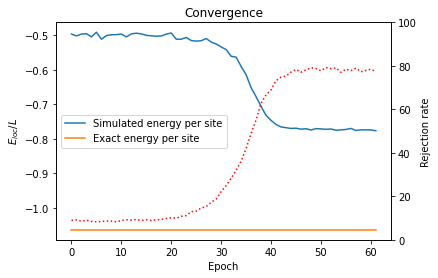

In [32]:
NQSrun = NQSRBM(1.,0.5,10,10,6000,0.4,62)
#
# Displaying analytics
#
Convergence,Percentage, aRBM, cRBM, WRBM, EexactPerSite = NQSrun    
Eexc = EexactPerSite*np.ones(Convergence.shape[0]-1)
fig, ax = plt.subplots()
ax.plot(Convergence[1:,0],Convergence[1:,1], label="Simulated energy per site")
ax.plot(Convergence[1:,0],Eexc, label="Exact energy per site")
ax2 = ax.twinx()
ax2.plot(Convergence[1:,0],Percentage[1:],color='red',linestyle=':', label="Rejection rate")
ax2.set_ylim(0,100)
ax.set_title('Convergence')
ax.set_xlabel('Epoch')
ax.set_ylabel(r'${E_{loc}}/{L}$')
ax2.set_ylabel("Rejection rate")
ax.legend()
fig;